# Monophonic Pitch Transcription
This notebook contains notes for monophonic pitch transcription for a private dataset of monophonic guitar recordings. The required output is then validated against a ground truth of the following format :



<textarea cols = "35" rows = "7">
<transcription>
  <event>
    <onsetSec> 1.932 </onsetSec>
    <pitch> 45 </pitch>
    <offsetSec> 2.4581 </offsetSec>
  </event>
</transcription>
</textarea>

The output is then validated with a ground truth xml file.

### Assumptions
* Sound files have a default sampling rate of 44100
* Pitch values are between 82 Hz - 660 Hz
* Event properties :
    * onset and offset times are in seconds from beginningOfFile
    * pitch value is the midi equivalent
    

### 1) Environment Setup

In [6]:
# Install librosa
print('Installing Librosa and dependencies...\n')

# TODO: Comment only for repeated testing. Uncomment for first run to install dependencies
!pip install -q librosa


# Importing os for file handling
import os

# and numpy for mathematical operations
import numpy as np

# and librosa for audio manipulation
import librosa 
import librosa.display

# for xml parsing
import xml.etree.ElementTree as ET

# for audio output
import IPython.display as ipd
from __future__ import print_function

# for visualiaztions
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 3)

import scipy

SAMPLE_RATE = 44100
hop_length = 100
    
currentPath = os.getcwd()
inputPath = os.path.join(currentPath,'Dataset/')
outputPath = os.path.join(currentPath,'Output/')

try: 
    os.makedirs(outputPath)
except OSError:
    if not os.path.isdir(outputPath):
        raise
        
get_name = lambda f: os.path.splitext(os.path.basename(f))[0]
        
print('Sucess!! Environment is now setup.')

Installing Librosa and dependencies...

Populating the interactive namespace from numpy and matplotlib
Sucess!! Environment is now setup.


### 2) Observing the data
The data consists of 6 licks, each having 3 versions played on 3 different guitars. Lets take one of the sounds to examine.

In [121]:
# Change Filename to test for any other file in the Dataset

filename = 'FS_Lick3.wav'
audioFile = os.path.join(inputPath, filename)

audio, sr = librosa.load(audioFile, SAMPLE_RATE)
ipd.Audio(audio, rate = SAMPLE_RATE)

#### Observing the Constant Q transform (CQT) of the signal.

Note : The CQT is similar to the DFT but unlike the DFT where the bin sizes across all the frequencies are constant, a CQT has a logrithmically spaced filter bank. This is though a little slower than the FFT implementation of the DFT, it is better suited for musical applications.

{Ref original paper - <a href="http://academics.wellesley.edu/Physics/brown/pubs/cq1stPaper.pdf">Judith C. Brown, "Calculation of a constant Q spectral transform," J. Acoust. Soc. Am., 89(1):425–434, 1991. </a> }

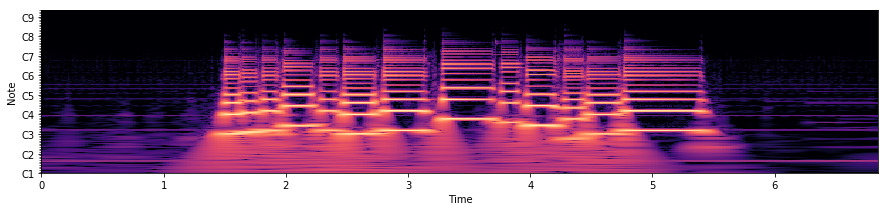

In [122]:
no_bins_per_octave = 36

cqt = librosa.cqt(audio, 
                  sr = SAMPLE_RATE, 
                  n_bins = 300, 
                  bins_per_octave = no_bins_per_octave)

cqt_mag = librosa.magphase(cqt, power = 2)[0]
log_cqt = librosa.power_to_db(cqt_mag)

librosa.display.specshow(log_cqt, 
                         sr = SAMPLE_RATE, 
                         x_axis = 'time', y_axis = 'cqt_note', 
                         bins_per_octave = no_bins_per_octave);

The processing of the audio files is divided into two parts. The first Onset detection stage (Timing) and the Pitch estimation stage (Tune). After the processing, evaluation is performed on the ground truth xml file provided.

In this jupyter notebook, the algorithm is run for one audio file. The provided monophonicTranscription.py implements a complete evaluation.

### 3) Onset  (Timing)

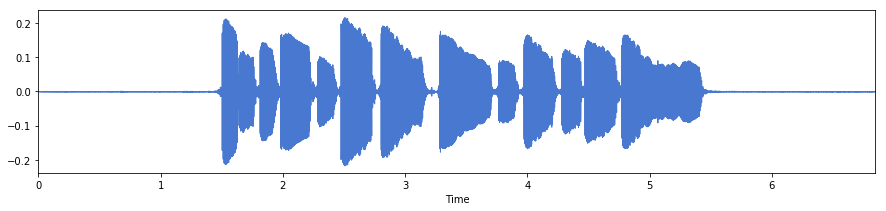

In [123]:
plt.figure()
librosa.display.waveplot(audio, sr = SAMPLE_RATE);

Onset Strength envelope is obtained as the smoothened spectral flux from the power log mel spectrogram of the audio signal.

(0, 3021)

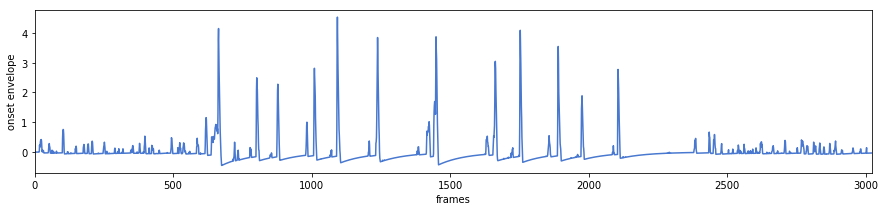

In [124]:
o_env = librosa.onset.onset_strength(audio, SAMPLE_RATE, 
                                     aggregate = np.median, 
                                     detrend = True,
                                     fmax = 2000, 
                                     n_mels = 128,
                                     hop_length = hop_length)

plt.plot(o_env)
plt.ylabel('onset envelope') 
plt.xlabel('frames')
plt.xlim(0,len(o_env))

Peaks are picked from the onset envelope giving us the onset boundaries

In [125]:
onset_samples = librosa.onset.onset_detect(onset_envelope = o_env,
                                           units='samples',
                                           sr = SAMPLE_RATE, 
                                           hop_length = hop_length,
                                           backtrack = False,
                                           pre_max = 0,
                                           post_max = 50,
                                           pre_avg = 0,
                                           post_avg = 100,
                                           delta = 0.25,
                                           wait = 50)

# Concatenating the last boundary as the end of file
onset_boundaries = np.concatenate([onset_samples, [len(audio)]])

In [126]:
onset_times = librosa.samples_to_time(onset_boundaries, sr = SAMPLE_RATE)
onsetSequence = onset_times
print(onset_boundaries)
print(len(onset_times))

[ 66400  80200  87800 101000 109300 123800 144900 166300 175300 189000
 197600 210600 302048]
13


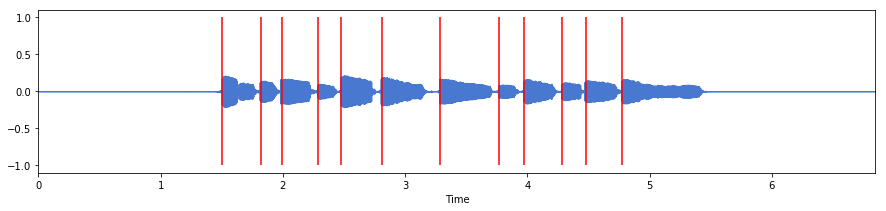

In [127]:
librosa.display.waveplot(audio, sr = SAMPLE_RATE);
plt.vlines(onset_times, -1, 1, color='r');

### 4) Estimating Pitch (Tune)

A simple autocorrelation is performed on each of the segments obtained from the detected onsets. A common method for pitch estimation is detecting the highest value of autocorrelation in the region of interest. If a signal has periodicity P samples, the autocorrelation of the signal also has the same periodicity P samples.

In [128]:
def pitch_segment(segment, sr, fmin=80.0, fmax=700.0):
    
    # Autocorrelation of segment
    autocorr = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    autocorr[:int(i_min)] = 0
    autocorr[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = autocorr.argmax()
    f0 = float(sr)/i
    
    return f0

Create a F0 sequence for the entire audio

Here frame_length for calculating pitch in short time windows is taken as 1104 samples.
The smallest frequency we wish to detect is ~ 80Hz. One period of 80Hz is 44100/80 = 552 samples.   
  
We need atleast two periods of the pitch we wish to detect so that the autocorrelation gives one peak at 0 lag and another at the second overlapping time delay. Thus (552 * 2 = 1104 samples) is chosen as the window. We also truncate the autocorrelation outside out desired range of fundamental frequencies.

In [129]:
frame_length_pitch = 1104
hop_length_pitch = frame_length_pitch//4

def estimate_pitch_segmentation(audio, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]

    # A hanning window is added to the short time windows for minimizing side lobe contributions because of windowing
    window = scipy.signal.hann(frame_length_pitch, sym=False)
    
    # Taking a bunch of frames from the onset boundary to half way between the next onset boundary
    frames = librosa.util.frame(audio[n0: n0 + ((n1 - n0)//2)], frame_length = frame_length_pitch, hop_length = hop_length_pitch)
    
    # pitches stores the estimated pitch in each short time frame 
    pitches = [pitch_segment(frames[:,index] * window, SAMPLE_RATE) for index in range(frames.shape[1])]
    
    # the pitch for a single onset is aggregated as the median of the pitches in the short time frames
    f0 = np.median(pitches)
    
    return f0

print("Processing autocorrelation in each onset segment using short time frames")
pitchSequence = [estimate_pitch_segmentation(audio, onset_boundaries, i, SAMPLE_RATE) for i in range(len(onset_boundaries)-1)]
print("\nPitch Estimation Successful!")

Processing autocorrelation in each onset segment using short time frames

Pitch Estimation Successful!


### 5) Evaluation against ground truth

Using the evaluation methods indicated in the problem statement provided and a reference to MIREX 2018 <a href = 'http://www.music-ir.org/mirex/wiki/2018:Audio_Onset_Detection'>(Onset Detections)</a>

* Onsets (Timing) : The detected onset times will be compared with the ground-truth ones. For a given ground-truth onset time, if there is a detection in a tolerance time-window around it (X msec), it is considered as a correct detection (CD). If not, there is a false negative (FN). The detections outside all the tolerance windows are counted as false positives (FP). With this we define

    * Precision P = CD / (CD + FP) 
    * Recall R = CD / (CD + FN)
    * F-measure F = 2*P*R/(P+R)

    
* Pitch (Tune) : Pitch is validated only for the correct detection (CD) onsets with the ground truth. 
    * Raw Pitch accuracy (RPA) : Note tune found to be correct if within X cents with ground truth.
    * Raw Chroma accuracy (RCA) : Note tune found to be correct disregarding octave errors, 

There are also other interesting evaluation metrics for merged onsets and duplicate onsets, which I do not investigate in this notebook.

In [130]:
groundtruthFilename = filename[:-4] + '.xml'
gtFile = os.path.join(inputPath,groundtruthFilename)

# Parsing the xml ground truth file
tree = ET.parse(gtFile)
root = tree.getroot()

In [131]:
# Generating the Ground Truth Sequences for Pitch and Onset
gtOnsetSequence = [float(root[i][0].text) for i in range(len(root))]
gtMidiSequence = [int(root[i][1].text) for i in range(len(root))]

# Converting the pitches into Hz from midi
gtPitchSequence = [librosa.midi_to_hz(gtMidiSequence[i]) for i in range(len(gtMidiSequence))]

#### Evaluation of Timing

In [132]:
# Because of the inaccuracy of ground truth annotations threshold shouldn't be < 0.05 (50msec)
onset_threshold = 0.06

def compare_onset_events(event, truth, onset_threshold):
    
    e_index = 0
    t_index = 0
    count_CD = 0.0
    count_FP = 0.0
    count_FN = 0.0
    
        
    # Array to keep track of the correctly detected onset positions, 
    # sequence
    sequence_CD = [-1] * len(onsetSequence)
    
    while t_index < len(truth):
        
        # Within threshold 
        if np.abs(event[e_index] - truth[t_index]) <= onset_threshold:
            
            #test
            #print("CD", event[e_index],truth[t_index])
            count_CD += 1
            sequence_CD[e_index] = int(t_index)
            t_index += 1
            e_index += 1
            
        # False Positive    
        elif event[e_index] < truth[t_index]:
            
            #test
            #print("FP", event[e_index],truth[t_index])
            e_index += 1
            count_FP += 1
        
        # False Negative
        else :
            
            #test
            #print("FN", event[e_index],truth[t_index])
            t_index += 1
            count_FN += 1
            
    return count_CD, count_FP, count_FN, sequence_CD

In [133]:
CD, FP, FN, sequence_CD = compare_onset_events(onsetSequence, gtOnsetSequence, onset_threshold)

Precision = CD / (CD + FP)
Recall = CD / (CD + FN)
Fmeasure = (2*Precision*Recall)/(Precision + Recall)
print("Correct Detections = ", CD," out of ", len(gtOnsetSequence) , "\nFalse Positives = ", FP, "\nFalse Negatives = ", FN, " \n\n")
print("Precision = ", Precision,"\nRecall =", Recall,"\nF-measure =", Fmeasure)

Correct Detections =  12.0  out of  13 
False Positives =  0.0 
False Negatives =  1.0  


Precision =  1.0 
Recall = 0.9230769230769231 
F-measure = 0.9600000000000001


#### Evaluation of Tune

In [134]:
def hertz_to_cents(freq_hz, base_frequency = 10.0):
    
    freq_cent = np.zeros(freq_hz.shape[0])
    normalized_frequency = np.abs(freq_hz)/base_frequency
    freq_cent = 1200*np.log2(normalized_frequency)
    
    return freq_cent

base_frequency = min(gtPitchSequence)

pitchSequence_cents = hertz_to_cents(np.array(pitchSequence), base_frequency)
print(pitchSequence_cents)

gtPitchSequence_cents = hertz_to_cents(np.array(gtPitchSequence), base_frequency)
print(gtPitchSequence_cents)
                                                

[ 321.30354568  519.37464121  817.61644457  525.21354741  321.30354568
  525.21354741 1212.60804152 1015.47770626  831.5220137    16.9633496
  316.1124352   519.37464121]
[ 300.  400.  500.  800.  500.  300.  500. 1200. 1000.  800.    0.  300.
  500.]


In [135]:
def pitch_evaluation(pitchSequence, gtPitchSequence, sequence_CD, tuneThreshold = 50): 
    #Raw Pitch accuracy and Raw Chroma accuracy
    nRPA = 0.0
    nRCA = 0.0
    CD_counter = 0
    
    base_frequency = min(gtPitchSequence)
    pitchSequence_cents = hertz_to_cents(np.array(pitchSequence), base_frequency)
    gtPitchSequence_cents = hertz_to_cents(np.array(gtPitchSequence), base_frequency)
      
    for i in range(len(pitchSequence_cents)):
        if sequence_CD[i] != -1:
            CD_counter += 1
            
            #print(pitchSequence_cents[i], " ", gtPitchSequence_cents[sequence_CD[i]], " ", i)
            if abs(pitchSequence_cents[i] - gtPitchSequence_cents[sequence_CD[i]]) <= tuneThreshold:
                nRPA += 1
                nRCA += 1
            # Pitch halving
            elif abs(2*pitchSequence_cents[i] - gtPitchSequence_cents[sequence_CD[i]]) <= tuneThreshold:
                nRCA += 1
            # Pitch doubling
            elif abs(0.5*pitchSequence_cents[i] - gtPitchSequence_cents[sequence_CD[i]]) <= tuneThreshold:
                nRCA += 1
            
    RPA = nRPA/len(gtPitchSequence_cents) * 100
    RCA = nRCA/len(gtPitchSequence_cents) * 100
    OA = nRPA/CD_counter * 100

    return RPA, RCA, OA

tune_threshold = 50
RPA, RCA, OA = pitch_evaluation(pitchSequence, gtPitchSequence, sequence_CD, tune_threshold)
print("Raw Pitch Accuracy = ", RPA, "\nRaw Chroma Accuracy =", RCA)
print("Overall Accuracy for all correctly detected onsets = ", OA)

Raw Pitch Accuracy =  92.3076923076923 
Raw Chroma Accuracy = 92.3076923076923
Overall Accuracy for all correctly detected onsets =  100.0


### 6) Analyzing for entire Dataset
I collect the above codes into three functions 1) Onset_detection, 2) Pitch_detection and 3) Evaluation for processing over the entire dataset

In [101]:
def onset_detection(audio, sr, hop_length):
    
    o_env = librosa.onset.onset_strength(audio, sr, 
                                     aggregate = np.median, 
                                     detrend = True,
                                     fmax = 2000, 
                                     n_mels = 128,
                                     hop_length = hop_length)
    onset_samples = librosa.onset.onset_detect(onset_envelope = o_env,
                                           units='samples',
                                           sr = sr, 
                                           hop_length = hop_length,
                                           backtrack = False,
                                           pre_max = 0,
                                           post_max = 50,
                                           pre_avg = 0,
                                           post_avg = 100,
                                           delta = 0.15,
                                           wait = 50)

    # Concatenating the last boundary as the end of file
    onset_boundaries = np.concatenate([onset_samples, [len(audio)]])
    onset_times = librosa.samples_to_time(onset_boundaries, sr = SAMPLE_RATE)
    onsetSequence = onset_times
    
    return onset_boundaries, onsetSequence

def pitch_detection(audio, sr, onset_boundaries):
    
    # Shortest window required to detect 80Hz signal (no of samples for atleast 2 periods) = 25 ms
    frame_length_pitch = 1104
    hop_length_pitch = frame_length_pitch//4
    
    pitchSequence = [estimate_pitch_segmentation(audio, onset_boundaries, i, sr) for i in range(len(onset_boundaries)-1)]
    
    return pitchSequence

# Onset_threshold is in seconds, Tune_threshold is in cents
def evaluation(filename, onsetSequence, pitchSequence, onset_threshold = 0.06, tune_threshold = 50) :
    
    groundtruthFilename = filename[:-4] + '.xml'
    gtFile = os.path.join(inputPath,groundtruthFilename)

    # Parsing the xml ground truth file
    tree = ET.parse(gtFile)
    root = tree.getroot()
    
    # Generating the Ground Truth Sequences for Pitch and Onset
    gtOnsetSequence = [float(root[i][0].text) for i in range(len(root))]
    gtMidiSequence = [int(root[i][1].text) for i in range(len(root))]

    # Converting the pitches into Hz from midi
    gtPitchSequence = [librosa.midi_to_hz(gtMidiSequence[i]) for i in range(len(gtMidiSequence))]
    
    CD, FP, FN, sequence_CD = compare_onset_events(onsetSequence, gtOnsetSequence, onset_threshold)
    Precision = CD / (CD + FP)
    Recall = CD / (CD + FN)
    Fmeasure = (2*Precision*Recall)/(Precision + Recall)
    
    RPA, RCA, OA = pitch_evaluation(pitchSequence, gtPitchSequence, sequence_CD, tune_threshold)
    
    return Precision, Recall, Fmeasure, RPA, RCA, OA

### 7) Conclusion

In [120]:
Precision, Recall, Fmeasure, RPA, RCA, OA, filenames, result = ([] for i in range(8))

for file in os.listdir(inputPath):
    if file.endswith(".wav"):
         
        # Loading audio
        audioFile = os.path.join(inputPath, file)
        audio, sr = librosa.load(audioFile, SAMPLE_RATE)
        
        # Onset Detection
        onset_boundaries, onsetSequence = onset_detection(audio, sr, hop_length)
        
        # Pitch Detection
        pitchSequence = pitch_detection(audio, sr, onset_boundaries)
        
        #Evaluation
        filename = get_name(file) + '.wav'
        filenames.append(get_name(file))
        
        p, r, f, rpa, rca, oa = evaluation(filename, onsetSequence, pitchSequence,  onset_threshold = 0.06, tune_threshold = 50)
        print('Processing ', filename)
        print('precision = ', p,' recall = ', r, ' fmeasure = ', f, ' rpa = ', rpa)
    
        Precision.append(p)
        Recall.append(r)
        Fmeasure.append(f)
        RPA.append(rpa)
        RCA.append(rca)
        OA.append(oa)
        
        result.append([filename,p,r,f,rpa,rca,oa])
        
print('***************************************************************************')        
print('Cumulative average metrics for the algorithm across the dataset are \n')
print('Precision =', mean(Precision))
print('Recall =', mean(Recall))
print('Fmeasure =', mean(Fmeasure))
print('RPA =', mean(RPA))
print('RCA =', mean(RCA))
print('Accuracy of correctly detected onsets =', mean(OA))

Processing  AR_Lick1.wav
precision =  0.9285714285714286  recall =  1.0  fmeasure =  0.962962962962963  rpa =  100.0
Processing  AR_Lick2.wav
precision =  0.7  recall =  1.0  fmeasure =  0.8235294117647058  rpa =  100.0
Processing  AR_Lick3.wav
precision =  0.8125  recall =  1.0  fmeasure =  0.896551724137931  rpa =  100.0
Processing  AR_Lick4.wav
precision =  0.7058823529411765  recall =  1.0  fmeasure =  0.8275862068965517  rpa =  100.0
Processing  AR_Lick5.wav
precision =  0.7692307692307693  recall =  1.0  fmeasure =  0.8695652173913044  rpa =  100.0
Processing  AR_Lick6.wav
precision =  0.7142857142857143  recall =  1.0  fmeasure =  0.8333333333333333  rpa =  100.0
Processing  FS_Lick1.wav
precision =  1.0  recall =  1.0  fmeasure =  1.0  rpa =  100.0
Processing  FS_Lick2.wav
precision =  0.8076923076923077  recall =  1.0  fmeasure =  0.8936170212765957  rpa =  100.0
Processing  FS_Lick3.wav
precision =  1.0  recall =  0.9230769230769231  fmeasure =  0.9600000000000001  rpa =  92.